In [ ]:
import numpy as np
import pandas as pd
from scipy import stats

import matplotlib.pyplot as plt

CSV_PATH = "lionstudios_data_analyst_take_home.csv"

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

### Load & Quick overview

In [2]:
parse_dates = ["install_timestamp", "session_timestamp"]

df = pd.read_csv(
    CSV_PATH,
    parse_dates=parse_dates,
    keep_default_na=True,
)

df.head()

,user_id,platform,variant,install_timestamp,country_type,session_timestamp,icon_shop_opens,inter_shop_opens,icon_cash_purchases,inter_cash_purchases,icon_revenue_usd,inter_revenue_usd,session_length,rvs_watched,levels_played
0,GZeZClCIqP,android,Control,2023-01-07 13:55:32.394000+00:00,Non-US,2023-01-07 13:55:32,0,0,0,0,0.0,0.0,53,2,31
1,GZeZClCIqP,android,Control,2023-01-07 13:55:32.394000+00:00,Non-US,2023-01-07 16:02:11,0,0,0,0,0.0,0.0,23,3,7
2,GZeZClCIqP,android,Control,2023-01-07 13:55:32.394000+00:00,Non-US,2023-01-08 07:05:13,0,0,0,0,0.0,0.0,4,10,11
3,GZeZClCIqP,android,Control,2023-01-07 13:55:32.394000+00:00,Non-US,2023-01-08 09:19:40,0,0,0,0,0.0,0.0,31,19,6
4,nPdXCigYaj,android,Control,2023-01-13 02:16:05.361000+00:00,Non-US,2023-01-13 02:16:05,0,0,0,0,0.0,0.0,27,13,5


In [3]:
numeric_cols = [
    "icon_shop_opens", "inter_shop_opens",
    "icon_cash_purchases", "inter_cash_purchases",
    "icon_revenue_usd", "inter_revenue_usd",
    "session_length", "rvs_watched", "levels_played",
]

for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors="coerce")

df["variant"] = df["variant"].map({
    "New Shop Icon": "treatment",
    "Control": "control"
}).fillna(df["variant"])

# Drop microseconds and keep everything UTC-aware
df["session_timestamp"] = df["session_timestamp"].dt.tz_localize("UTC").dt.floor("S")
df["install_timestamp"] = df["install_timestamp"].dt.floor("S")

df["install_date"] = df["install_timestamp"].dt.date
df["session_date"] = df["session_timestamp"].dt.date

df["total_revenue_usd"] = df["icon_revenue_usd"] + df["inter_revenue_usd"]
df["total_cash_purchases"] = df["icon_cash_purchases"] + df["inter_cash_purchases"]
df["total_shop_opens"] = df["icon_shop_opens"] + df["inter_shop_opens"]

In [4]:
# Checking for sessions started before installation

df[df["session_timestamp"] < df["install_timestamp"]]

,user_id,platform,variant,install_timestamp,country_type,session_timestamp,icon_shop_opens,inter_shop_opens,icon_cash_purchases,inter_cash_purchases,icon_revenue_usd,inter_revenue_usd,session_length,rvs_watched,levels_played,install_date,session_date,total_revenue_usd,total_cash_purchases,total_shop_opens


In [5]:
print("Rows:", len(df))
print("Users:", df["user_id"].nunique())
print("Variants:", df["variant"].value_counts(dropna=False).to_dict())
print("Platforms:", df["platform"].value_counts(dropna=False).to_dict())
print("Country types:", df["country_type"].value_counts(dropna=False).to_dict())

Rows: 73141
Users: 20000
Variants: {'control': 41924, 'treatment': 31217}
Platforms: {'android': 36972, 'ios': 36169}
Country types: {'Non-US': 53601, 'US': 19540}


In [6]:
print("\nTime ranges:")
print("  install:", df["install_timestamp"].min(), "→", df["install_timestamp"].max())
print("  session:", df["session_timestamp"].min(), "→", df["session_timestamp"].max())


Time ranges:
  install: 2023-01-01 00:01:18+00:00 → 2023-01-14 23:59:39+00:00
  session: 2023-01-01 00:01:18+00:00 → 2023-02-01 09:25:41+00:00


### Analysis of missing values

In [7]:
null_rate = df.isna().mean().sort_values(ascending=False) * 100
null_rate

session_date            0.006836
session_timestamp       0.006836
user_id                 0.000000
inter_revenue_usd       0.000000
total_cash_purchases    0.000000
total_revenue_usd       0.000000
install_date            0.000000
levels_played           0.000000
rvs_watched             0.000000
session_length          0.000000
icon_revenue_usd        0.000000
platform                0.000000
inter_cash_purchases    0.000000
icon_cash_purchases     0.000000
inter_shop_opens        0.000000
icon_shop_opens         0.000000
country_type            0.000000
install_timestamp       0.000000
variant                 0.000000
total_shop_opens        0.000000
dtype: float64

In [8]:
df[df["session_timestamp"].isna()]

,user_id,platform,variant,install_timestamp,country_type,session_timestamp,icon_shop_opens,inter_shop_opens,icon_cash_purchases,inter_cash_purchases,icon_revenue_usd,inter_revenue_usd,session_length,rvs_watched,levels_played,install_date,session_date,total_revenue_usd,total_cash_purchases,total_shop_opens
13031,rQHkV9Y6Bf,android,control,2023-01-13 13:40:50+00:00,Non-US,NaT,0,0,0,0,0.0,0.0,9,24,20,2023-01-13,NaT,0.0,0,0
13032,rQHkV9Y6Bf,android,control,2023-01-13 13:40:50+00:00,Non-US,NaT,2,2,0,0,0.0,0.0,41,6,19,2023-01-13,NaT,0.0,0,4
47965,tl8b0Wfku3,android,treatment,2023-01-07 00:40:34+00:00,Non-US,NaT,0,1,0,0,0.0,0.0,40,4,15,2023-01-07,NaT,0.0,0,1
55729,7vQrKSWcQA,android,treatment,2023-01-01 07:00:00+00:00,Non-US,NaT,1,0,0,0,0.0,0.0,18,7,21,2023-01-01,NaT,0.0,0,1
55730,7vQrKSWcQA,android,treatment,2023-01-01 07:00:00+00:00,Non-US,NaT,0,0,0,0,0.0,0.0,10,12,12,2023-01-01,NaT,0.0,0,0


There are only five missing values in the session_timestamp column, so we can simply delete them.

In [9]:
df.dropna(inplace=True)

### Basic summary of numeric columns & Duplicate check

In [10]:
df[numeric_cols].describe(percentiles=[.01, .05, .25, .5, .75, .95, .99]).T

,count,mean,std,min,1%,5%,25%,50%,75%,95%,99%,max
icon_shop_opens,73136.0,0.115073,0.517494,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,5.0
inter_shop_opens,73136.0,0.139412,0.560188,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,5.0
icon_cash_purchases,73136.0,0.040678,0.369959,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,7.0
inter_cash_purchases,73136.0,0.092704,0.756418,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,14.0
icon_revenue_usd,73136.0,0.165650,1.556546,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,34.0
inter_revenue_usd,73136.0,0.213739,1.768146,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,34.0
session_length,73136.0,29.693817,17.038792,1.0,3.0,7.0,17.0,27.0,40.0,62.0,78.0,103.0
rvs_watched,73136.0,12.748824,7.808739,0.0,1.0,2.0,7.0,12.0,17.0,27.0,35.0,50.0
levels_played,73136.0,15.482184,9.749071,0.0,1.0,3.0,8.0,14.0,21.0,34.0,44.0,61.0


In [11]:
print(f"Duplicates in total: {df.duplicated().sum()}")
print(f"Duplcates by user_id, session_timestamp: {df.duplicated(subset=['user_id', 'session_timestamp']).sum()}")

Duplicates in total: 0
Duplcates by user_id, session_timestamp: 0


### Histograms for Numerical columns

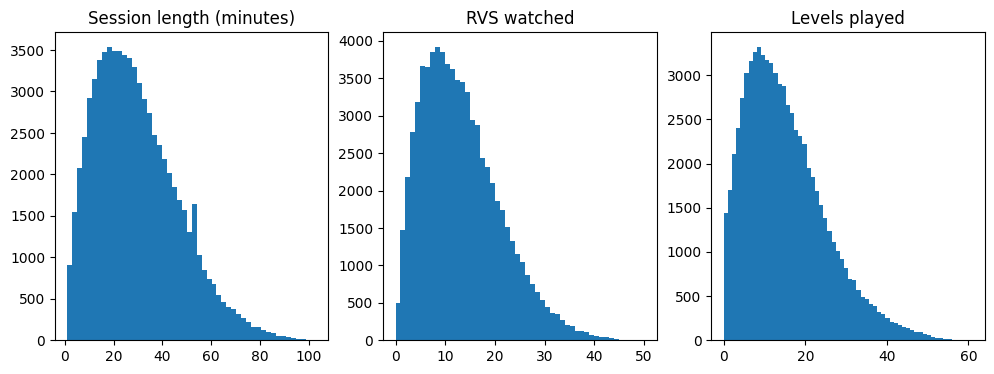

In [12]:
fig, axes = plt.subplots(1, 3, figsize=(12,4))
axes[0].hist(df["session_length"], bins=50)
axes[0].set_title("Session length (minutes)")
axes[1].hist(df["rvs_watched"], bins=50)
axes[1].set_title("RVS watched")
axes[2].hist(df["levels_played"], bins=60)
axes[2].set_title("Levels played")
plt.show()

All three distributions are skewed to the right: most users have short sessions, few RVS views, and a small number of levels played, while long tails are formed by a relatively small proportion of very active players.

The distributions look smooth, without abnormal outliers, which is typical for behavioral data in games.

This form confirms that it is better to use robust methods to analyze these metrics, rather than relying solely on normal assumptions.

Text(0.5, 1.0, 'Inter revenue per session')

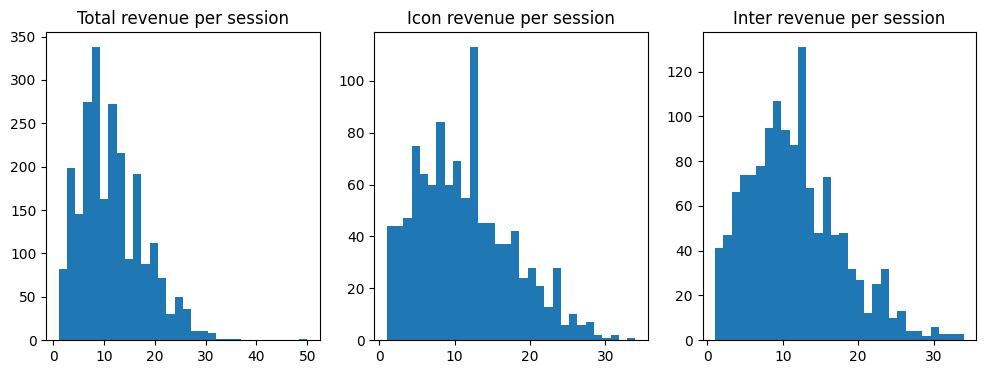

In [13]:
fig, axes = plt.subplots(1, 3, figsize=(12,4))
axes[0].hist(df[df["total_revenue_usd"] != 0]["total_revenue_usd"], bins=30)
axes[0].set_title("Total revenue per session")
axes[1].hist(df[df["icon_revenue_usd"] != 0]["icon_revenue_usd"], bins=30)
axes[1].set_title("Icon revenue per session")
axes[2].hist(df[df["inter_revenue_usd"] != 0]["inter_revenue_usd"], bins=30)
axes[2].set_title("Inter revenue per session")

The distributions are also strongly skewed to the right: most of the sessions bring low revenue (or zero), while a small number of sessions give a noticeably higher value.

There is significant variability and discrete peaks, reflecting the structure of transactions (fixed price packages and frequency of purchases).

This confirms that revenue is a heavy distribution with "thick tails"

Let's take a quick look at cannibalization

In [14]:
channel = df.groupby("variant")[["icon_revenue_usd","inter_revenue_usd"]].sum()
channel["icon_share"] = channel["icon_revenue_usd"] / (channel["icon_revenue_usd"]+channel["inter_revenue_usd"]).replace(0,np.nan)
channel.round(4)


,icon_revenue_usd,inter_revenue_usd,icon_share
variant,,,
control,6369.0,10246.0,0.3833
treatment,5746.0,5386.0,0.5162


The new option shifts the revenue structure: users are more likely to pay through the icon rather than through other entry points.

At the same time, the total amount of revenue decreased: $16,615 (control) → $11,132 (treatment), that is, by about -33%.

In [15]:
# Derived per-session totals

display(
    df.groupby("variant")[["total_shop_opens","total_cash_purchases","total_revenue_usd","session_length"]]
      .mean()
      .round(4)
)

,total_shop_opens,total_cash_purchases,total_revenue_usd,session_length
variant,,,,
control,0.2523,0.1440,0.3963,27.7842
treatment,0.2575,0.1192,0.3566,32.2586


The metrics recalculated for the session show that the new design worsens the overall user value: engagement and monetization are falling

### SRM check

I decided to check the sample ratio mismatch to make sure that the data is divided by users in a 20/80 ratio between treatment and control. To do this, I used a binomial test that evaluates whether the proportion of “successes” in the sample differs significantly from the hypothetical probability with a binomial distribution.

Assumptions of this test:
1. The variable must have a binary outcome
2. Observations should be independent
3. The experiment should have a fixed sample size
4. All observations should have the same probability of outcome

The two-way binomial test is suitable for SRM checks, since the task is precisely to check whether the observed proportion of assignment corresponds to the expected probability during randomization, which is naturally modeled by a binomial distribution.

In [16]:
obs_t = df[df["variant"] == "treatment"]["user_id"].nunique()
obs_n = df["user_id"].nunique()
obs_share = obs_t / obs_n
print(f"Observed treatment share: {obs_share} (expected {0.2})")

binomtest_res = stats.binomtest(k=obs_t, n=obs_n, p=0.2, alternative="two-sided")
print(f"SRM binomial p-value: {binomtest_res.pvalue}")


Observed treatment share: 0.5302 (expected 0.2)
SRM binomial p-value: 0.0


53% of the “treatment" is a giant SRM vs the expected 20%. It seems that the actual allocation wasn't 20/80 (e.g., ~50/50) or changed mid-test.

Let's check the dynamics of SRM by day

In [17]:
variant_per_user = (df.sort_values("session_timestamp")
                      .groupby("user_id", as_index=False)
                      .first()[["user_id", "variant", "country_type", "platform", "install_date"]])

srm_dynamics = (variant_per_user.groupby(["install_date", "variant"])["user_id"].nunique()
                                .unstack(fill_value=0))

srm_dynamics["n"] = srm_dynamics.sum(axis=1)
srm_dynamics["treat_share"] = srm_dynamics["treatment"] / srm_dynamics["n"]
srm_dynamics["p_value"] = srm_dynamics.apply(lambda r: stats.binomtest(
    k=int(r["treatment"]), n=int(r["n"]), p=0.20, alternative="two-sided").pvalue, axis=1)

display(srm_dynamics)
print("Median daily treat_share:", srm_dynamics["treat_share"].median().round(3))


variant,control,treatment,n,treat_share,p_value
install_date,,,,,
2023-01-01,658,718,1376,0.521802,2.933635e-154
2023-01-02,725,742,1467,0.505794,1.296358e-149
2023-01-03,660,771,1431,0.538784,2.921488e-176
2023-01-04,676,782,1458,0.536351,3.529804e-177
2023-01-05,675,742,1417,0.523641,1.818771e-160
2023-01-06,721,784,1505,0.520930,1.094920e-167
2023-01-07,688,795,1483,0.536076,6.568109e-180
2023-01-08,677,822,1499,0.548366,2.805304e-194
2023-01-09,653,751,1404,0.534900,2.433540e-169


Median daily treat_share: 0.534


Let's also check if it can be a 50/50 split

In [19]:
binomtest_res = stats.binomtest(k=(variant_per_user["variant"]=="treatment").sum(),
    n=len(variant_per_user), p=0.5, alternative="two-sided")
print(binomtest_res.pvalue)


1.3735048671798163e-17


This is a hard SRM fail at the planned 20/80 ratio and even at the 50/50 ratio.

Here are a few reasons why this could happen:
1. The data contains users with more than 1 session. If many installations have not been started, and this somehow correlates with the division into treatment and control, then there may be a group bias.
2. The split was 50/50, but due to some problems, SRM is observed.

Let's check balance across country/platform stratum with chi-square test of independence of variables in a contingency table.
The null hypothesis is that the distribution of options does not depend on the stratum (for example, choosing ios or android does not change the likelihood of treatment).

Assumptions of this test:
1. The data format. They should be presented as a table with calculations for each combination of categories
2. Independence of observations
3. The expected frequency. To get reliable results, the expected frequency for each cell in the table must be at least 5

I use the chi-square criterion in the balance check because it generalizes the binomial test to multi-pass contingency tables, allowing us to verify the independence of treatment assignment from categorical covariates such as country, platform, or date.

In [20]:
for col in ["country_type", "platform", "install_date"]:
    crosstab = pd.crosstab(variant_per_user[col], variant_per_user["variant"])
    chi2, p, dof, _ = stats.chi2_contingency(crosstab)
    print(f"{col} balance: p={p:.4g}, dof={dof}")
    display(crosstab.assign(row_total=crosstab.sum(axis=1)).assign(
        treatment_share=lambda x: (x["treatment"] / x["row_total"]).round(3)
    ))

country_type balance: p=5.307e-33, dof=1


variant,control,treatment,row_total,treatment_share
country_type,,,,
Non-US,7299,7445,14744,0.505
US,2097,3159,5256,0.601


platform balance: p=0.6637, dof=1


variant,control,treatment,row_total,treatment_share
platform,,,,
android,5053,5669,10722,0.529
ios,4343,4935,9278,0.532


install_date balance: p=0.2848, dof=13


variant,control,treatment,row_total,treatment_share
install_date,,,,
2023-01-01,658,718,1376,0.522
2023-01-02,725,742,1467,0.506
2023-01-03,660,771,1431,0.539
2023-01-04,676,782,1458,0.536
2023-01-05,675,742,1417,0.524
2023-01-06,721,784,1505,0.521
2023-01-07,688,795,1483,0.536
2023-01-08,677,822,1499,0.548
2023-01-09,653,751,1404,0.535


It can be seen from the test results that country_type is not balanced between treatment and control.

### Calculation of user-level KPIs

The primary KPI was chosen as shop opens via icon in 24h because it is a direct reflection of the goal of the experiment — to increase clicks on the new icon and, consequently, entrances to the shop. It is simple, binary and quickly fixed, which allows you to unambiguously verify the hypothesis.

Additional KPIs include shop opening metrics (icon_opens_*, inter_opens_*, total_shop_opens_*), which allow you to understand whether the new icon design really increases user interest in the shop on the first day and on the horizon of the week. Next, the purchase metrics (icon_purch_*, inter_purch_*, total_purch_*) are evaluated to check whether the increase in visits is converted into real transactions. In addition, revenue metrics (icon_revenue_*, inter_rev_*, total_revenue_*) are considered, reflecting the impact of changes on monetization in both the short and medium horizons.

Guardrail Metrics include engagement and retention metrics: minutes_*, rvs_*, levels_*. These metrics make sure that the new design does not reduce the total time spent in the game, the number of RVS viewed, and level progress.

In [21]:
d0_window = pd.Timedelta("24h")
d7_window = pd.Timedelta("7D")

def aggregate_user_window(df: pd.DataFrame, window: pd.Timedelta, label: str) -> pd.DataFrame:
    """Aggregate sessions per user within [install, install+window)."""
    in_window_df = (df["session_timestamp"] >= df["install_timestamp"]) & \
                   (df["session_timestamp"] < df["install_timestamp"] + window)

    user_df = (df.loc[in_window_df]
        .groupby("user_id")
        .agg(
            icon_opens_sum=("icon_shop_opens", "sum"),
            inter_opens_sum=("inter_shop_opens", "sum"),
            icon_purch_sum=("icon_cash_purchases", "sum"),
            inter_purch_sum=("inter_cash_purchases", "sum"),
            icon_rev_sum=("icon_revenue_usd", "sum"),
            inter_rev_sum=("inter_revenue_usd", "sum"),
            sessions_count=( "session_timestamp", "count"),
            minutes_sum=("session_length", "sum"),
            rvs_sum=("rvs_watched", "sum"),
            levels_sum=("levels_played", "sum"),
            )
        .reset_index()
        )
    user_df[f"did_open_icon_{label}"] = (user_df["icon_opens_sum"] > 0).astype(int)
    user_df[f"any_purchase_icon_{label}"] = (user_df["icon_purch_sum"] > 0).astype(int)
    user_df[f"total_shop_opens_{label}"] = user_df["icon_opens_sum"] + user_df["inter_opens_sum"]
    user_df[f"total_purch_{label}"] = user_df["icon_purch_sum"] + user_df["inter_purch_sum"]
    user_df[f"total_revenue_{label}"] = user_df["icon_rev_sum"] + user_df["inter_rev_sum"]

    user_df.rename(columns={
        "icon_opens_sum": f"icon_opens_{label}",
        "inter_opens_sum": f"inter_opens_{label}",
        "icon_purch_sum": f"icon_purch_{label}",
        "inter_purch_sum": f"inter_purch_{label}",
        "inter_rev_sum": f"inter_rev_{label}",
        "icon_rev_sum": f"icon_revenue_{label}",
        "sessions_count": f"sessions_{label}",
        "minutes_sum": f"minutes_{label}",
        "rvs_sum": f"rvs_{label}",
        "levels_sum": f"levels_{label}",
    }, inplace=True)

    return user_df


In [22]:
user_d0 = aggregate_user_window(df, d0_window, "24h")
user_d7 = aggregate_user_window(df, d7_window, "7d")

In [23]:
users_df = (variant_per_user
    .merge(user_d0, on="user_id", how="left")
    .merge(user_d7, on="user_id", how="left"))

Let's plot daily primary KPI dynamics

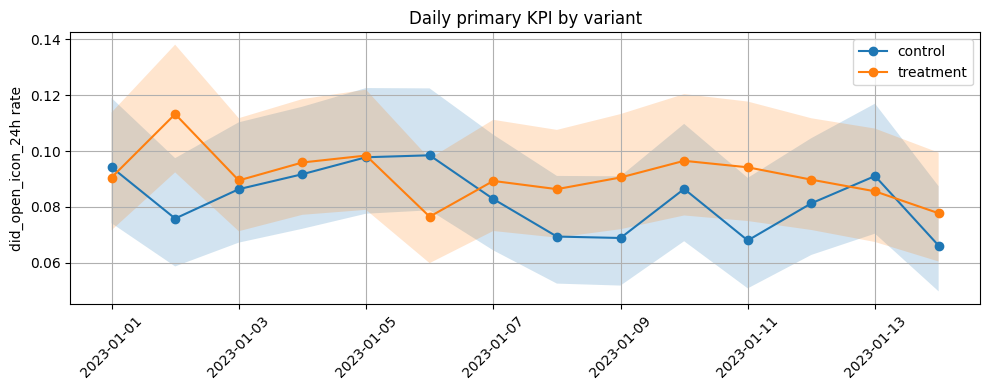

In [24]:
import statsmodels.api as sm

primary_kpi_daily = (users_df
                     .groupby(["install_date", "variant"])["did_open_icon_24h"]
                     .agg(["sum", "count"])
                     .reset_index())

primary_kpi_daily["rate"] = primary_kpi_daily["sum"] / primary_kpi_daily["count"]

ci_low, ci_high = sm.stats.proportion_confint(
    count=primary_kpi_daily["sum"], 
    nobs=primary_kpi_daily["count"], 
    alpha=0.05,
    method="wilson"
)

primary_kpi_daily["ci_low"] = ci_low
primary_kpi_daily["ci_high"] = ci_high

plt.figure(figsize=(10,4))
for variant in ["control", "treatment"]:
    variant_subset = primary_kpi_daily[primary_kpi_daily["variant"] == variant]
    plt.plot(variant_subset["install_date"], variant_subset["rate"], 
             marker="o", label=variant)
    plt.fill_between(
        variant_subset["install_date"], 
        variant_subset["ci_low"], 
        variant_subset["ci_high"], 
        alpha=0.2
    )
plt.ylabel("did_open_icon_24h rate")
plt.title("Daily primary KPI by variant")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid()
plt.show()


In most cases, the treatment line is located above the control line. However, the confidence intervals overlap over the entire time interval, which means that the treatment group does not show statistically significant changes in the dynamics of primary KPIs.

To evaluate the effect based on the primary KPI, I used the Stratified Two-Proportion Z-Test.

This test evaluates the difference in conversions between treatment and control. In each stratum (by country_type and platform), the conversions of both groups are calculated, after which the difference is combined using inverse variance weighting. The z-statistic is defined as the ratio of the total difference to its standard error, and the p-value is calculated based on a standard normal distribution.

Assumptions of this test:
1. The data within the stratum is independent
2. The sample size is large enough for a normal approximation of the binomial distribution
3. Fixed treatment vs control groups are compared

This test can be used because the did_open_icon_24h feature is binary, and the Z-test is well suited for proportions at n > ~30 per group. Stratification reduces bias in a heterogeneous population

In [ ]:
def stratified_z_test(df: pd.DataFrame,
                      metric: str="did_open_icon_24h",
                      stratum: tuple=("country_type", "platform"),
                      min_lift: float=0.10,
                      alpha: float=0.05) -> dict:
    """
    Stratified two-proportion z-test (risk difference with inverse-variance weighting).
    """

    per_stratum_rows = []
    for _, stratum_df in df.groupby(list(stratum)):
        treatment = stratum_df.loc[stratum_df["variant"] == "treatment", metric].astype(float)
        control   = stratum_df.loc[stratum_df["variant"] == "control",  metric].astype(float)
        if treatment.empty or control.empty:
            continue

        successes_treat, n_treat = treatment.sum(), treatment.size
        successes_ctrl,  n_ctrl  = control.sum(),  control.size
        treatment_rate = successes_treat / n_treat
        control_rate   = successes_ctrl  / n_ctrl

        risk_diff = treatment_rate - control_rate
        var_diff  = treatment_rate * (1 - treatment_rate) / n_treat + control_rate * (1 - control_rate) / n_ctrl

        per_stratum_rows.append((risk_diff, var_diff, treatment_rate, control_rate, n_treat, n_ctrl))

    if not per_stratum_rows:
        raise ValueError("No valid stratum with both treatment and control observations.")

    stratum_results = pd.DataFrame(
        per_stratum_rows,
        columns=["risk_diff", "var_diff", "treatment_rate", "control_rate", "n_treat", "n_ctrl"]
    )

    weights = 1.0 / stratum_results["var_diff"]
    weighted_diff = (weights * stratum_results["risk_diff"]).sum() / weights.sum()
    se_diff = np.sqrt(1.0 / weights.sum())

    z_stat = weighted_diff / se_diff
    p_value = 2.0 * (1.0 - stats.norm.cdf(abs(z_stat)))

    z_crit = stats.norm.ppf(1.0 - alpha / 2.0)
    ci_lower, ci_upper = weighted_diff - z_crit * se_diff, weighted_diff + z_crit * se_diff

    treatment_rate_overall = (stratum_results["treatment_rate"] * stratum_results["n_treat"]).sum() / stratum_results["n_treat"].sum()
    control_rate_overall   = (stratum_results["control_rate"]   * stratum_results["n_ctrl"]).sum()  / stratum_results["n_ctrl"].sum()
    relative_lift = (treatment_rate_overall - control_rate_overall) / max(control_rate_overall, 1e-15)

    result = {
        "z_stat": round(z_stat, 3),
        "p_value": round(p_value, 4),
        "ci_95": (round(ci_lower, 4), round(ci_upper, 4)),
        "control_rate": round(control_rate_overall, 4),
        "treatment_rate": round(treatment_rate_overall, 4),
        "relative_lift": f"{relative_lift:.2%}",
        "min_required_lift": f"{min_lift:.2%}",
        "meets_criterion": (relative_lift >= min_lift) and (p_value < alpha)
    }

    return result

In [32]:
res = stratified_z_test(users_df)

for key, value in res.items():
    print(f"{key}: {value}")


z_stat: 2.004
p_value: 0.045
ci_95: (0.0002, 0.0158)
control_rate: 0.0828
treatment_rate: 0.0909
relative_lift: 9.79%
min_required_lift: 10.00%
meets_criterion: False


The relative effect turned out to be statistically significant (p-value = 0.045 < 0.05), however, its value of +9.79% does not reach the ship-target effect.

For secondary and guardrail KPIs, I used the stratified Welch t-test. It compares mean values of continuous metrics (minutes, revenue, levels, purchases).

In each stratum, the difference of the averages with the Welch variance is calculated, then the results are combined by inverse weighting of the variances. The effective degrees of freedom are determined by the Satterthwaite approximation, after which the t-statistic is calculated as the ratio of the total difference to its standard error, and the p-value is taken from the Student's distribution.

Assumptions of this test:
1. The data within the stratum is independent
2. Means are approximately normally distributed (CLT applies given sample sizes)
3. The Welch adjustment takes into account the unequal differences between the groups

This approach is suitable because KPIs are non-binary, measured on continuous or count scales. The Welch t-test is also resistant to unequal group sizes and their differences.

In [ ]:
def stratified_mean_diff_ttest(df: pd.DataFrame, 
                               metric: str, 
                               stratum: tuple=("country_type", "platform"), 
                               alpha: float=0.05):
    """
    Stratified Welch t-test for non-binary KPIs with fixed-effect meta-analysis.
    """

    per_stratum_rows = []
    for _, stratum_df in df.groupby(list(stratum)):
        treatment = stratum_df.loc[stratum_df["variant"] == "treatment", metric].astype(float)
        control   = stratum_df.loc[stratum_df["variant"] == "control",  metric].astype(float)
        
        if treatment.empty or control.empty:
            continue

        n_treat, n_ctrl = treatment.size, control.size
        mean_treat, mean_ctrl = treatment.mean(), control.mean()
        var_treat, var_ctrl   = treatment.var(ddof=1), control.var(ddof=1)

        var_diff = var_treat/n_treat + var_ctrl/n_ctrl

        num   = var_diff**2
        denom = (var_treat/n_treat)**2 / max(n_treat-1, 1) + (var_ctrl/n_ctrl)**2 / max(n_ctrl-1, 1)
        df_stratum  = num/denom if denom > 0 else np.inf

        per_stratum_rows.append((mean_treat - mean_ctrl, var_diff, n_treat, n_ctrl, mean_treat, mean_ctrl, df_stratum))

    if not per_stratum_rows:
        raise ValueError("No valid stratum with both treatment and control observations.")

    stratum_results = pd.DataFrame(
        per_stratum_rows,
        columns=["mean_diff","var_diff","n_treat","n_ctrl","mean_treat","mean_ctrl","df_stratum"]
    )

    weights = 1.0 / stratum_results["var_diff"]
    pooled_diff = (weights * stratum_results["mean_diff"]).sum() / weights.sum()
    se_diff     = np.sqrt(1.0 / weights.sum())

    # Satterthwaite effective df for the aggregate
    denom_df = (weights**2 / stratum_results["df_stratum"]).replace([np.inf, np.nan], 0.0).sum()
    df_eff = (weights.sum()**2) / denom_df if denom_df > 0 else np.inf

    # t-test two-sided
    t_stat = pooled_diff / se_diff
    if np.isfinite(df_eff):
        p_value = 2 * (1 - stats.t.cdf(abs(t_stat), df=df_eff))
        t_crit  = stats.t.ppf(1 - alpha/2, df=df_eff)
    else:
        p_value = 2 * (1 - stats.norm.cdf(abs(t_stat)))
        t_crit  = stats.norm.ppf(1 - alpha/2)

    ci_abs_low, ci_abs_high = pooled_diff - t_crit * se_diff, pooled_diff + t_crit * se_diff

    mean_treat_overall = (stratum_results["mean_treat"]*stratum_results["n_treat"]).sum() / stratum_results["n_treat"].sum()
    mean_ctrl_overall  = (stratum_results["mean_ctrl"]*stratum_results["n_ctrl"]).sum()  / stratum_results["n_ctrl"].sum()

    rel_lift = (mean_treat_overall - mean_ctrl_overall) / max(mean_ctrl_overall, 1e-15)
    grad = 1.0 / max(mean_ctrl_overall, 1e-15)
    se_rel = abs(grad) * se_diff

    return {
        "metric": metric,
        "t_stat": round(t_stat, 3),
        "p_value": float(f"{p_value:.4g}"),
        "diff_abs": round(pooled_diff, 6),
        "ci_95": f"[{ci_abs_low:.6f}, {ci_abs_high:.6f}]",
        "mean_treat": round(mean_treat_overall, 6),
        "mean_control": round(mean_ctrl_overall, 6),
        "relative_lift": f"{rel_lift:.2%}",
    }


In [ ]:
metrics = [
    "icon_opens_24h", "inter_opens_24h", "total_shop_opens_24h",
    "icon_opens_7d", "inter_opens_7d", "total_shop_opens_7d",
    "icon_purch_24h", "inter_purch_24h", "total_purch_24h",
    "icon_purch_7d", "inter_purch_7d", "total_purch_7d",
    "icon_revenue_24h", "inter_rev_24h", "total_revenue_24h",
    "icon_revenue_7d", "inter_rev_7d", "total_revenue_7d",
    "minutes_24h", "rvs_24h", "levels_24h",
    "minutes_7d", "rvs_7d", "levels_7d",
]

results_df = pd.DataFrame([stratified_mean_diff_ttest(users_df, m) for m in metrics if m in users_df.columns])
results_df.sort_values("diff_abs").reset_index(drop=True)

,metric,t_stat,p_value,diff_abs,ci_95,mean_treat,mean_control,relative_lift
0,rvs_7d,-46.292,0.000000e+00,-17.682824,"[-18.431564, -16.934084]",33.425971,52.252129,-36.03%
1,minutes_7d,-17.433,0.000000e+00,-14.406465,"[-16.026295, -12.786634]",92.009619,107.624095,-14.51%
2,levels_7d,-15.564,0.000000e+00,-6.498337,"[-7.316760, -5.679915]",48.309129,55.588442,-13.10%
3,rvs_24h,-21.330,0.000000e+00,-4.684749,"[-5.115254, -4.254243]",17.311675,22.254576,-22.21%
4,inter_opens_7d,-16.999,0.000000e+00,-0.259744,"[-0.289694, -0.229793]",0.340343,0.599936,-43.27%
5,total_shop_opens_7d,-11.590,0.000000e+00,-0.244195,"[-0.285493, -0.202898]",0.736137,0.981162,-24.97%
6,total_revenue_7d,-4.271,1.964000e-05,-0.164645,"[-0.240215, -0.089075]",1.024425,1.500639,-31.73%
7,inter_rev_7d,-5.528,3.319000e-08,-0.156405,"[-0.211869, -0.100941]",0.498774,0.921137,-45.85%
8,total_purch_7d,-5.738,9.800000e-09,-0.088679,"[-0.118971, -0.058387]",0.343550,0.540336,-36.42%
9,inter_purch_7d,-6.255,4.124000e-10,-0.086712,"[-0.113887, -0.059537]",0.214353,0.398893,-46.26%


Almost all 7-day engagement metrics (rvs_7d, minutes_7d, levels_7d) deteriorated sharply: drops from -13% to -36%, p-value ≪ 0.001.

This means that despite the "almost completed" primary KPI, the solution is not ready for rollout, because there is a pronounced deterioration in key guardrails (retention, revenue).

Also, SRM by country_type reduces the credibility of the experiment — we cannot be sure that the effects are not caused by an imbalance.

Conclusion: 

Do not roll out the solution. If the team wants to return to the idea, it is worth looking for a compromise design that increases clicks on the icon, but does not spoil other KPIs/guardrails.

It may be worth restarting the experiment with the corrected randomization mechanism to eliminate the SRM and get clean results.